In [1]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt
import plotly.express as px

# pandas
import pandas as pd

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import MobileNetV2

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

In [2]:
#path Gaston
#path = '/home/usuario/CelebFaces/'

#path Lautaro
path = 'CelebFaces/'
# Construir las rutas completas para cada archivo
list_attr_celeba = os.path.join(path, 'list_attr_celeba.csv')
list_eval_partition = os.path.join(path, 'list_eval_partition.csv')
img_align_celeba = os.path.join(path, 'img_align_celeba/img_align_celeba')

# Cargar el archivo de atributos
df_atributos = pd.read_csv(list_attr_celeba)

# Cargar el archivo de partición
df_particiones  = pd.read_csv(list_eval_partition)

## Analisis Exploratorio

### 1.1 Volumetria de datos

In [3]:
df_atributos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

In [4]:
df_atributos

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,-1,1,-1,1,1,-1,1,-1,-1,1


In [5]:
print("Cantidad de imágenes: ", len(df_atributos.image_id))
print("Cantidad de atributos: ", df_atributos.shape[1])

Cantidad de imágenes:  202599
Cantidad de atributos:  41


In [6]:
df_atributos = df_atributos[['image_id', 'No_Beard']]
df_atributos['No_Beard'] = df_atributos['No_Beard'].replace({-1 : 0, 1 : 1 }) 
df_atributos["No_Beard"] = df_atributos["No_Beard"].astype(str)
merged = pd.merge(df_particiones, df_atributos, on='image_id')

/var/folders/y2/j95xkz_95q76p9h31311j_8w0000gp/T/ipykernel_7980/1090598992.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atributos['No_Beard'] = df_atributos['No_Beard'].replace({-1 : 0, 1 : 1 })
/var/folders/y2/j95xkz_95q76p9h31311j_8w0000gp/T/ipykernel_7980/1090598992.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atributos["No_Beard"] = df_atributos["No_Beard"].astype(str)


- Nos quedamos con la columna image_id y nuestro target.
- Reemplazamos los valores -1 a 0 para un manejo mas transparente de nuestra variable.

In [7]:
train = merged[merged['partition'] == 0]
val = merged[merged['partition'] == 1]
test = merged[merged['partition'] == 2]

**A partir de la columna partition generamos los 3 conjuntos de datos por separado.**

In [8]:
train = train.drop('partition', axis=1)
val = val.drop('partition', axis=1)
test = test.drop('partition', axis=1)

Luego de realizar el agrupamiento eliminamos la columna que no nos va a ser útil.

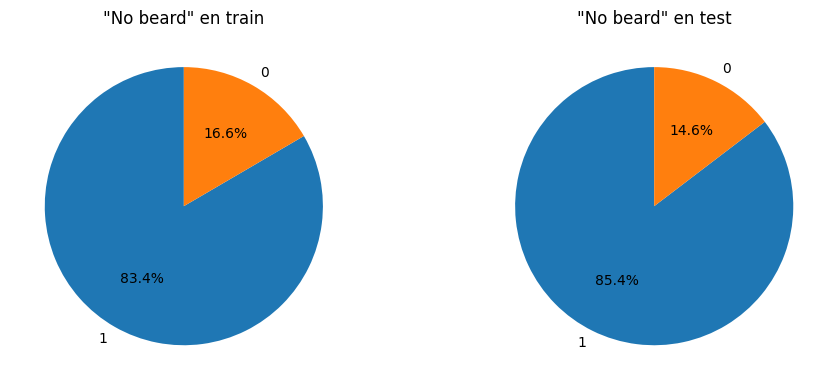

In [9]:
train_counts = train['No_Beard'].value_counts()

test_counts = test['No_Beard'].value_counts()

# figura y ejes con 1 fila y 2 columnas
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].pie(train_counts.values, labels=train_counts.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('"No beard" en train')

axs[1].pie(test_counts.values, labels=test_counts.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('"No beard" en test')

plt.tight_layout()
plt.show()

**Podemos notar un gran desbalanceo en los datos en ambos conjuntos.**

### 1.2 Estructura y tipo de las imágenes

A continuación generamos un nuevo dataset re-escalando las imagenes y re-dimensionando a un tamaño de 128x128 en cada conjunto de datos.

In [10]:
SIZE = 128
train_datagen = ImageDataGenerator(rescale=1./255)

resized_train = train_datagen.flow_from_dataframe(
    train, 
    img_align_celeba + "/", 
    x_col='image_id',
    y_col='No_Beard',
    target_size=(SIZE, SIZE),
    class_mode='binary'
)

Found 162770 validated image filenames belonging to 2 classes.


In [11]:
val_datagen = ImageDataGenerator(rescale=1./255)

resized_val = val_datagen.flow_from_dataframe(
    val, 
    img_align_celeba + "/", 
    x_col='image_id',
    y_col='No_Beard',
    target_size=(SIZE, SIZE),
    class_mode='binary',
)

Found 19867 validated image filenames belonging to 2 classes.


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

resized_test = test_datagen.flow_from_dataframe(
    test, 
    img_align_celeba + "/",  
    x_col='image_id',
    y_col=None,
    target_size=(SIZE, SIZE),
    class_mode=None
)

Found 19962 validated image filenames.


#### Función para mostrar imagenes

In [14]:
def display_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    images, labels = dataset.next()
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        #plt.title(labels[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

**Ejemplo imagenes re-dimensionadas en train**

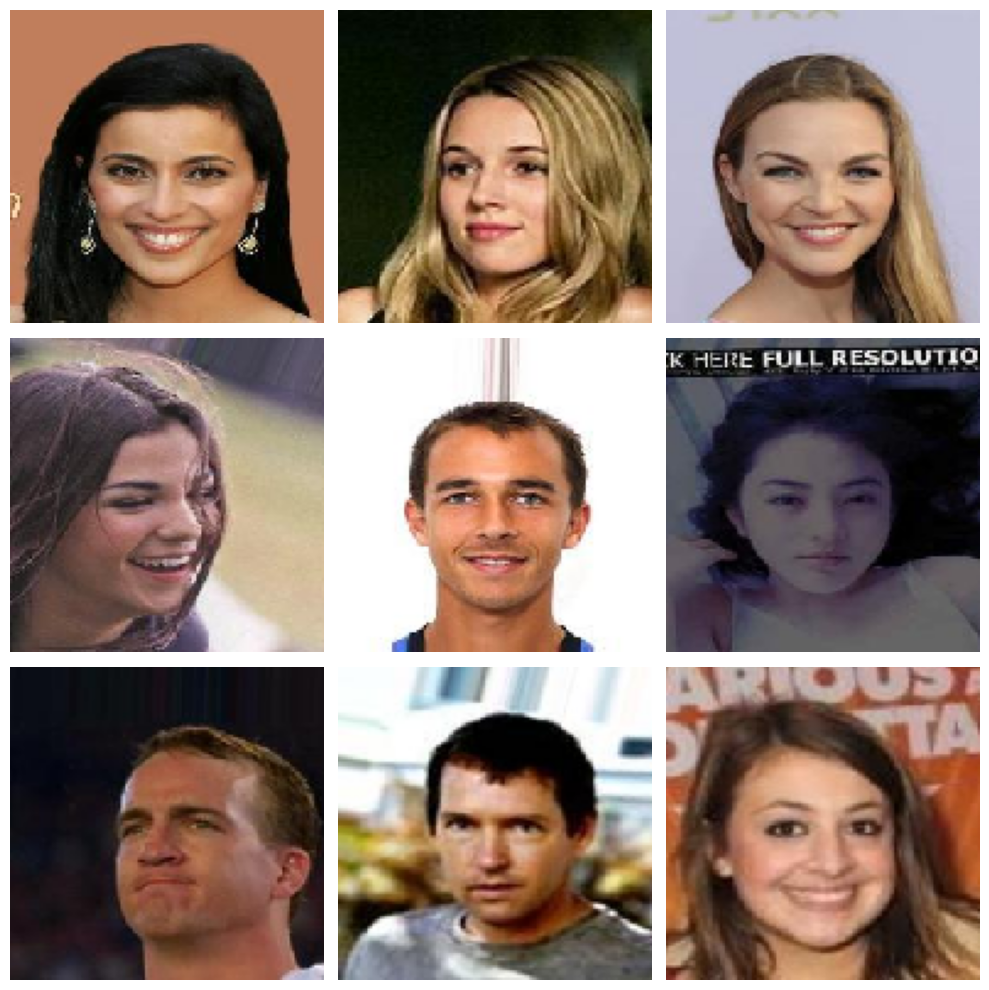

In [15]:
display_images(resized_train)

**Ejemplo imagenes re-dimensionadas en validation**

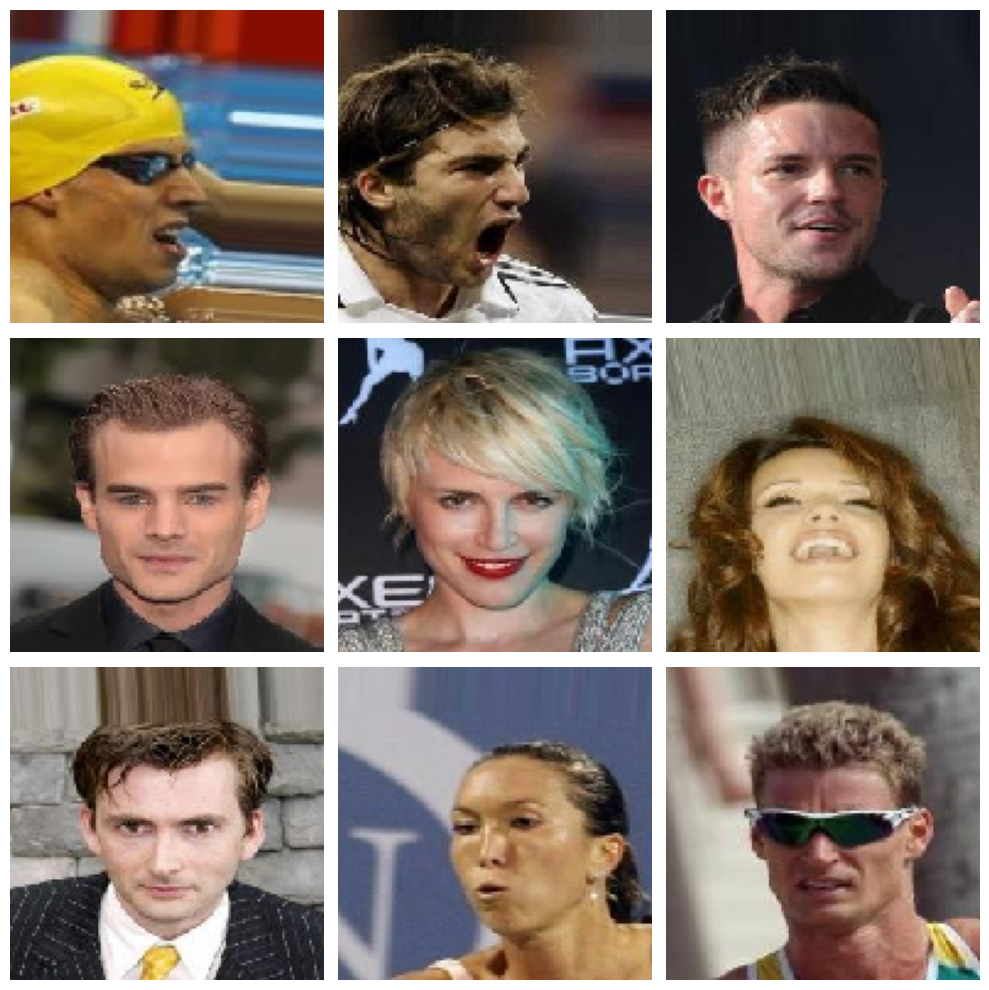

In [16]:
display_images(resized_val)

### 1.3 Distribución de la variable a predecir

In [19]:
# Obtener los valores de recuento
value_counts = train['No_Beard'].value_counts()

# Crear el gráfico de distribución con los valores de recuento
fig = px.bar(x=value_counts.index, y=value_counts.values, labels={'x': 'No_Beard', 'y': 'Count'},
             title='Distribución de la variable "No_Beard" en el conjunto de train')

fig.update_traces(text=value_counts.values, texttemplate='%{text}', textposition='inside')

fig.show()

In [20]:
# Obtener los valores de recuento
value_counts = val['No_Beard'].value_counts()

# Crear el gráfico de distribución con los valores de recuento
fig = px.bar(x=value_counts.index, y=value_counts.values, labels={'x': 'No_Beard', 'y': 'Count'},
             title='Distribución de la variable "No_Beard" en el conjunto de validation')

fig.update_traces(text=value_counts.values, texttemplate='%{text}', textposition='inside')

fig.show()

## 2. Machine Learning

### I) MLP Simple

In [21]:
input_shape = (SIZE, SIZE, 3)

In [ ]:
# MLP simple
model = Sequential([
    Flatten(input_shape=input_shape,),

    Dense(128, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [ ]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

In [ ]:
history = model.fit(
    resized_train,
    epochs=15,
    batch_size=128,
    validation_data=val,
    callbacks=[OurCustomCallback()]
)

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()